# Imports

In [21]:
!pip install -U albumentations
!pip install split-folders


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [22]:
import numpy as np
import os
import shutil
from tqdm import tqdm
import zipfile
import urllib.request
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import ResNet152_Weights, ResNet50_Weights
import random
import time
import copy
import matplotlib.pyplot as plt
import splitfolders
import data_augmenter

In [23]:
def plot_classes_preds(images, labels, preds, probs):
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx + 1, xticks=[], yticks=[])
        norm_img = cv2.normalize(images[idx].cpu().numpy(), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        rgb_img = np.transpose(norm_img, (1, 2, 0)).astype(np.uint8)
        plt.imshow(rgb_img)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            preds[idx],
            probs[idx] * 100.0,
            labels[idx]),
            color=("green" if preds[idx] == labels[idx].item() else "red"))
    return fig

# Preprocess

In [24]:
np.random.seed(123)  # for replication

## Download the dataset

In [25]:
def download_file(url, file_name):
    if not os.path.exists('dataset/' + file_name):
        with urllib.request.urlopen(url) as response, open('dataset/' + file_name, 'wb') as out_file:
            content_length = int(response.headers['Content-Length'])
            with tqdm(total=content_length, unit='B', unit_scale=True, desc=url.split('/')[-1]) as pbar:
                while True:
                    chunk = response.read(1024)
                    if not chunk:
                        break
                    out_file.write(chunk)
                    pbar.update(len(chunk))
    else:
        print(f"{file_name} already exists.")


os.makedirs("dataset/", exist_ok=True)
# Check if the directory exists before trying to delete it
if os.path.exists('dataset/GTSRB/'):
    shutil.rmtree('dataset/GTSRB/')
    print("The folder 'dataset/GTSRB/' has been deleted successfully.")
else:
    print("The folder 'dataset/GTSRB/' does not exist.")
# Training
download_file('https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip',
              'GTSRB_Final_Training_Images.zip')
# Testing
download_file('https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip',
              'GTSRB_Final_Test_Images.zip')
# Ground truth
download_file('https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip',
              'GTSRB_Final_Test_GT.zip')

The folder 'dataset/GTSRB/' has been deleted successfully.
GTSRB_Final_Training_Images.zip already exists.
GTSRB_Final_Test_Images.zip already exists.
GTSRB_Final_Test_GT.zip already exists.


## Extract zip files

In [26]:
def extract_file(file_name):
    with zipfile.ZipFile(f"dataset/{file_name}", 'r') as zip_ref:
        file_list = zip_ref.namelist()
        with tqdm(total=len(file_list), desc="Extracting") as pbar:
            for file in file_list:
                zip_ref.extract(file, 'dataset/')
                pbar.update(1)


extract_file('GTSRB_Final_Training_Images.zip')
extract_file('GTSRB_Final_Test_Images.zip')
extract_file('GTSRB_Final_Test_GT.zip')

Extracting: 100%|██████████| 1/1 [00:00<00:00, 458.59it/s]


## Loading CSV file

In [27]:
#IMAGES: './dataset/GTSRB/test_images'
#CSV ANNOTATIONS: './dataset/GTSRB/test_images/GT-final_test.csv'
def csv_loader(csv_path):
    data = np.loadtxt(csv_path,
                      delimiter=";", dtype=str, skiprows=1)
    return data


#You should download the testset ('GTSRB_Final_Test_Images.zip') from the website which contains only the images
#Then you have to download the ground truth csv ('GTSRB_Final_Test_GT.zip') from the website and paste it into the testset images folder
annotations = csv_loader('./dataset/GT-final_test.csv')
#sort the annotations
annotations = annotations[:, [0, 7]]
num_samples = len(annotations)
#Column 0: filename - Column 1: classid
annotations = annotations[annotations[:, 1].astype(int).argsort()]

## Making training data accordingly

In [28]:
def move_directories(source, destination):
    if not os.path.exists(destination):
        os.makedirs(destination)
    # Get a list of all directories in the source directory
    directories = [d for d in os.listdir(source) if os.path.isdir(os.path.join(source, d))]

    # Move each directory to the destination
    for directory in tqdm(directories):
        source_path = os.path.join(source, directory)
        destination_path = os.path.join(destination, directory)
        shutil.move(source_path, destination_path)


# Move directories with contents
move_directories("./dataset/GTSRB/Final_Training/Images", "./dataset/GTSRB/train")
shutil.rmtree("./dataset/GTSRB/Final_Training")

100%|██████████| 43/43 [00:00<00:00, 38357.10it/s]


## Making test data accordingly

In [29]:
for class_id in tqdm(np.unique(annotations[:, 1]), desc='Class_ID'):
    newpath = './dataset/GTSRB/test/' + class_id.zfill(5)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    for image_filename in annotations[annotations[:, 1] == class_id]:
        shutil.move('./dataset/GTSRB/Final_Test/Images/' + image_filename[0], newpath + '/' + image_filename[0])

shutil.rmtree("./dataset/GTSRB/Final_Test")

Class_ID: 100%|██████████| 43/43 [00:00<00:00, 102.96it/s]


## Merge the dataset and then split into train and test

In [30]:
def merge(source_folder, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get the total number of files and directories in the source folder
    total_items = sum([len(files) + len(dirs) for root, dirs, files in os.walk(source_folder)])

    # Initialize tqdm to show progress
    progress = tqdm(total=total_items, desc='Moving: ' + source_folder + ' --> ' + destination_folder, position=0, leave=True)

    # Iterate over all files and subdirectories in the source folder
    for root, dirs, files in os.walk(source_folder):
        for item in files + dirs:
            source_item = os.path.join(root, item)
            destination_item = os.path.join(destination_folder, os.path.relpath(source_item, source_folder))

            # If the item is a file, copy it to the destination folder
            if os.path.isfile(source_item):
                shutil.move(source_item, destination_item)
            # If the item is a directory, create it in the destination folder
            elif os.path.isdir(source_item):
                os.makedirs(destination_item, exist_ok=True)

            progress.update(1)  # Update progress bar

    progress.close()  # Close tqdm

def merge_folders(source_folders, target_folder):
    for sf in source_folders:
        merge(sf, target_folder)
        shutil.rmtree(sf)

# Temporary directory to store the merged dataset
merged_dir = "./dataset/GTSRB/merged"

merge_folders(['./dataset/GTSRB/train','./dataset/GTSRB/test'], merged_dir)

# Training 70
# Testing 30
splitfolders.ratio(merged_dir, output="./dataset/GTSRB/plain", seed=123, ratio=(.7,0, 0.3),move=False)

# Clear temporary files
shutil.rmtree('./dataset/GTSRB/plain/val')
os.remove('./dataset/GTSRB/Readme-Images-Final-test.txt')
os.remove('./dataset/GTSRB/Readme-Images.txt')

Moving: ./dataset/GTSRB/train --> ./dataset/GTSRB/merged: 100%|██████████| 39295/39295 [00:01<00:00, 19693.09it/s]
Moving: ./dataset/GTSRB/test --> ./dataset/GTSRB/merged: 100%|██████████| 12673/12673 [00:00<00:00, 21931.02it/s]
Copying files: 51882 files [00:09, 5389.48 files/s]


## Add weather conditions to the merged dataset and then split into train and test

In [31]:
da = data_augmenter.DataAugmenter(dataset_path='./dataset/GTSRB/')
da.load_images(folder_to_load='merged')
da.add_weather_effects(prob_per_class=0.5)

# Training 70
# Testing 30
splitfolders.ratio(merged_dir, output="./dataset/GTSRB/weather", seed=123, ratio=(.7,0, 0.3),move=True)

# Clear temporary files
shutil.rmtree('./dataset/GTSRB/weather/val')
shutil.rmtree(merged_dir)

Classes found: , 00016, 00033, 00022, 00011, 00003, 00039, 00034, 00035, 00028, 00036, 00037, 00015, 00027, 00038, 00014, 00026, 00019, 00007, 00029, 00005, 00008, 00021, 00025, 00032, 00002, 00000, 00024, 00009, 00012, 00023, 00013, 00041, 00030, 00017, 00006, 00042, 00018, 00040, 00020, 00010, 00031, 00004, 00001


Add weather effects with probability 0.5: 100%|██████████| 43/43 [00:31<00:00,  1.37it/s]
Copying files: 51882 files [00:03, 15679.56 files/s]


## Set dataset paths

In [32]:
plain_train_dir = './dataset/GTSRB/plain/train'
plain_test_dir = './dataset/GTSRB/plain/test'

weather_train_dir='./dataset/GTSRB/weather/train'
weather_test_dir='./dataset/GTSRB/weather/test'

# Parameters setup

In [33]:
# Setting device for the computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Change this to select between plain or weather dataset
# train_dir = plain_train_dir/weather_train_dir
# test_dir = plain_test_dir/weather_test_dir
train_dir = weather_train_dir
test_dir = weather_test_dir

# Hyperparameters
hyperparams = {
    "num_epochs": 15,
    "batch_size": 64,
    #optimizer
    "opt": "adam",
    "learning_rate": 1e-4,
    "beta_1": 0.9,
    "beta_2": 0.999,
    "eps": 1e-8,
    "weight_decay": 0,
    "momentum": 0,
    #scheduler
    "decay_rate": 0.5,
}

# Loading the training set

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Train size: 36288
Class names: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


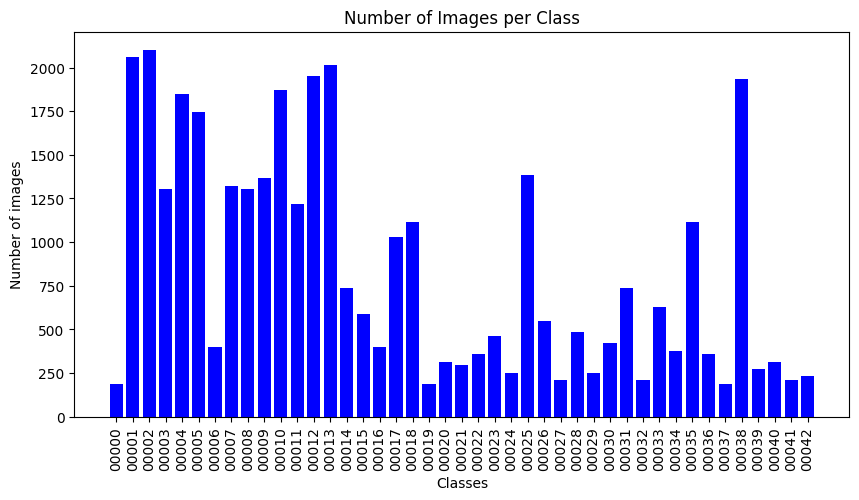

In [34]:
os.makedirs('./models', exist_ok=True)

# Define your transformations
custom_cnn_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
])

# Load the dataset using the torchvision.datasets.ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=custom_cnn_transform)

# Concatenate all images into a single tensor
images = torch.stack([img for img, _ in train_dataset], dim=0)

# Calculate mean and std across all images and channels
mean = torch.mean(images, dim=(0, 2, 3))
std = torch.std(images, dim=(0, 2, 3))

# Define your transformations
custom_cnn_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load the dataset using the torchvision.datasets.ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=custom_cnn_transform)

train_size = len(train_dataset)
class_names = train_dataset.classes
number_of_classes = len(train_dataset.classes)

print('Train size:', train_size)
print('Class names:', class_names)

# Use numpy to count occurrences of each class index in targets
train_samples_per_class = np.bincount(train_dataset.targets)

# Compute class weights
class_weights=(train_size/(number_of_classes*train_samples_per_class))
class_weights=torch.tensor(class_weights,dtype=torch.float)

# Create histogram
plt.figure(figsize=(10, 5))
plt.bar(class_names, train_samples_per_class, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)  # Rotate class names for better visibility if needed
plt.yticks(np.arange(0, max(train_samples_per_class) + 10, 250))  # Adjust the range and step size as needed
plt.show()

# Loading the test set

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Test size: 15551
Class names: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


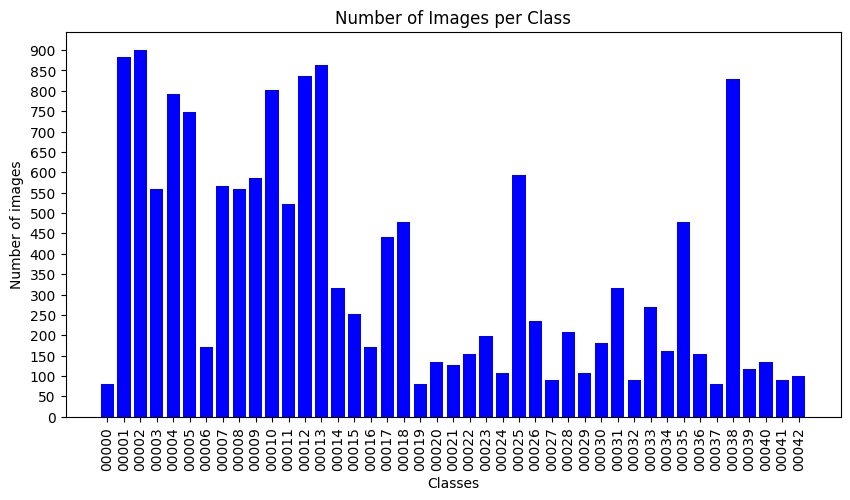

In [35]:
# Load the dataset using the torchvision.datasets.ImageFolder
test_dataset = datasets.ImageFolder(test_dir, transform=custom_cnn_transform)
test_size = len(test_dataset)
class_names = test_dataset.classes

print('Test size:', test_size)
print('Class names:', class_names)

# Use numpy to count occurrences of each class index in targets
counts = np.bincount(test_dataset.targets)

# Create histogram
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)  # Rotate class names for better visibility if needed
plt.yticks(np.arange(0, max(counts) + 10, 50))  # Adjust the range and step size as needed
plt.show()

# Defining the CNN

## CNN Plain

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Expected input as 48x48
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=200, kernel_size=7, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.local_norm = nn.LocalResponseNorm(size=5)

        self.conv2 = nn.Conv2d(in_channels=200, out_channels=250, kernel_size=4, stride=1, padding=2)

        self.conv3 = nn.Conv2d(in_channels=250, out_channels=350, kernel_size=4, stride=1, padding=2)

        self.fc1= nn.Linear(in_features=350*6*6, out_features=400)

        self.fc2= nn.Linear(in_features=400, out_features=43)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x= self.pool1(x)

        x = self.local_norm(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.local_norm(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.local_norm(x)

        # Flatten the output from conv1
        x = x.view(-1, 350*6*6)

        x= self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        return x

## CNN with 3 spatial transformers

In [37]:
class CNN_ST(nn.Module):
    def __init__(self):
        super().__init__()
        # Expected input as 48x48
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=200, kernel_size=7, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=200, out_channels=250, kernel_size=4, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=250, out_channels=350, kernel_size=4, stride=1, padding=2)

        self.local_norm = nn.LocalResponseNorm(size=5)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.fc1= nn.Linear(in_features=350*6*6, out_features=400)
        self.fc2= nn.Linear(in_features=400, out_features=43)

        # Spatial transformer block 1
        self.loc1=nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=3, out_channels=250, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=250, out_channels=250, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.fc_loc1 = nn.Sequential(
            nn.Linear(250 * 6 * 6, 250),
            nn.ReLU(True),
            nn.Linear(250, 6)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc1[2].weight.data.zero_()
        self.fc_loc1[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        # Spatial transformer block 2
        self.loc2=nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=200, out_channels=150, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=150, out_channels=200, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.fc_loc2 = nn.Sequential(
            nn.Linear(200 * 2 * 2, 300),
            nn.ReLU(True),
            nn.Linear(300, 6)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc2[2].weight.data.zero_()
        self.fc_loc2[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        # Spatial transformer block 3
        self.loc3=nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=250, out_channels=150, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=150, out_channels=200, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.fc_loc3 = nn.Sequential(
            nn.Linear(200 * 1 * 1, 300),
            nn.ReLU(True),
            nn.Linear(300, 6)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc3[2].weight.data.zero_()
        self.fc_loc3[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))


    def stn1(self,x):
        xs = self.loc1(x)
        xs = xs.view(-1, 250 * 6 * 6)
        theta = self.fc_loc1(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)

        return x

    def stn2(self,x):
        xs = self.loc2(x)
        xs = xs.view(-1, 200 * 2 * 2)
        theta = self.fc_loc2(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)

        return x

    def stn3(self,x):
        xs = self.loc3(x)
        xs = xs.view(-1, 200 * 1 * 1)
        theta = self.fc_loc3(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)

        return x

    def forward(self, x):
        # Spatial transformer 1
        x = self.stn1(x)

        # CNN block 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.local_norm(x)

        # Spatial transformer 2
        x = self.stn2(x)

        # CNN block 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.local_norm(x)

        # Spatial transformer 3
        x = self.stn3(x)

        # CNN block 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.local_norm(x)

        # Flatten the output for dense layers
        x = x.view(-1, 350*6*6)
        x= self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

## Training function

In [38]:
def test_model(trained_model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        trained_model.eval()
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = trained_model(images)
            softmax_outputs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(softmax_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = float(correct / total)
    print('{} Model accuracy: {:.4f}'.format('Test phase - ', test_accuracy))
    writer.add_scalar('Training/Test Accuracy', test_accuracy)
    return test_accuracy


def train_model(device, model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25,
                model_name='trained_model'):
    since = time.time()
    time_train = 0
    time_val = 0

    # Save the initial model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0

            # Choose the appropriate data loader
            if phase == 'train':
                model.train()  # Set model to training mode
                data_total_steps = len(train_loader)
                data_loader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                data_total_steps = len(val_loader)
                data_loader = val_loader

            for i, (images, labels) in enumerate(data_loader):
                # time_t = epoch * len(data_loader) * i + i

                images = images.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    softmax_outputs = F.softmax(outputs, dim=1)
                    probs, preds = torch.max(softmax_outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

                #prints the stats every 20 steps (20 batches performed)
                if (i + 1) % int(data_total_steps / 8) == 0:
                    print(
                        f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{data_total_steps}], Loss: {loss.item():.4f}')

                    # Log image predictions
                    selected_indices = random.sample(range(len(images)), 4)  # Select 4 random indices
                    selected_images = images[selected_indices]
                    selected_labels = labels[selected_indices]
                    selected_preds = preds[selected_indices]
                    selected_probs = probs[selected_indices]
                    if phase == 'train':
                        writer.add_figure('Training/Training Predictions',
                                          plot_classes_preds(selected_images, selected_labels, selected_preds,
                                                             selected_probs),
                                          global_step=time_train)
                    else:
                        writer.add_figure('Training/Validation Predictions',
                                          plot_classes_preds(selected_images, selected_labels, selected_preds,
                                                             selected_probs),
                                          global_step=time_val)

                # Log scalars
                if phase == 'train':
                    writer.add_scalar('Training/Training Loss',
                                      loss.item(),
                                      time_train)
                    writer.add_scalar('Policy/Learning Rate',
                                      np.array(scheduler.get_last_lr()),
                                      time_train)
                    time_train += 1
                else:
                    writer.add_scalar('Training/Validation Loss',
                                      loss.item(),
                                      time_val)
                    time_val += 1

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            if phase == 'train':
                print('{} Epoch {} Loss: {:.4f} Acc: {:.4f}'.format(
                    'Train phase - ', epoch + 1, epoch_loss, epoch_acc))
                writer.add_scalar('Training/Training Accuracy',
                                  epoch_acc,
                                  epoch)
                if (epoch + 1) % max(int(num_epochs / 5), 1) == 0:  # checkpoint the model
                    print("----> model checkpoint...")
                    torch.save(model, f'./models/trained_model_{model_name}_epoch_{epoch + 1}.pth')
            else:
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                print('{} Epoch {} Loss: {:.4f} Acc: {:.4f}'.format(
                    'Validation phase - ', epoch + 1, epoch_loss, epoch_acc))
                writer.add_scalar('Training/Validation Accuracy',
                                  epoch_acc,
                                  epoch)
                #scheduler.step(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc:{:.4f}'.format(best_acc))
    # Return the model with the best accuracy in the validation
    model.load_state_dict(best_model_wts)

    return model

## Model setting

In [39]:
# default `log_dir` is "runs" - we'll be more specific here
model_name = 'W_CNN_ST_adam'
writer = SummaryWriter(f'runs/{model_name}')

test_abs = int(len(train_dataset) * 0.8)
train_subset, val_subset = random_split(
    train_dataset, [test_abs, len(train_dataset) - test_abs])

train_data_size = len(train_subset)

# Create DataLoader instances for training and validation
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=hyperparams["batch_size"],
    shuffle=True,
    num_workers=0)
val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=hyperparams["batch_size"],
    shuffle=True,
    num_workers=0)
test_loader = DataLoader(
    test_dataset,
    batch_size=hyperparams["batch_size"],
    shuffle=True,
    num_workers=0)

# Model initialization
model = CNN_ST().to(device)

# Define loss function, optimizer, etc.
class_weights=class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Set optimizers
if hyperparams['opt'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams["learning_rate"],momentum=hyperparams["momentum"], weight_decay=hyperparams["weight_decay"])
elif hyperparams['opt'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], betas=(hyperparams["beta_1"],hyperparams["beta_2"]), eps=hyperparams["eps"], weight_decay=hyperparams["weight_decay"])
elif hyperparams['opt'] == 'rmsprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=hyperparams["learning_rate"])
else:
    raise ValueError('Invalid optimizer provided')
scheduler = lr_scheduler.ConstantLR(optimizer)

# Train the model

In [40]:
# Train model
trained_model = train_model(device=device, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                            train_loader=train_loader, val_loader=val_loader, num_epochs=hyperparams["num_epochs"],
                            model_name=model_name)

ta = test_model(trained_model=trained_model, test_loader=test_loader)

----------
Epoch 1/15
----------
Epoch [1/15], Step [56/454], Loss: 3.6781
Epoch [1/15], Step [112/454], Loss: 3.1866
Epoch [1/15], Step [168/454], Loss: 2.7574
Epoch [1/15], Step [224/454], Loss: 2.4297
Epoch [1/15], Step [280/454], Loss: 1.8816
Epoch [1/15], Step [336/454], Loss: 1.4332
Epoch [1/15], Step [392/454], Loss: 1.5252
Epoch [1/15], Step [448/454], Loss: 1.3520
Train phase -  Epoch 1 Loss: 2.5743 Acc: 0.2963
Epoch [1/15], Step [14/114], Loss: 1.5947
Epoch [1/15], Step [28/114], Loss: 1.2735
Epoch [1/15], Step [42/114], Loss: 1.4752
Epoch [1/15], Step [56/114], Loss: 1.2867
Epoch [1/15], Step [70/114], Loss: 1.2036
Epoch [1/15], Step [84/114], Loss: 1.2975
Epoch [1/15], Step [98/114], Loss: 1.3615
Epoch [1/15], Step [112/114], Loss: 1.2878
Validation phase -  Epoch 1 Loss: 1.3882 Acc: 0.5814
----------
Epoch 2/15
----------
Epoch [2/15], Step [56/454], Loss: 1.3641
Epoch [2/15], Step [112/454], Loss: 1.0368
Epoch [2/15], Step [168/454], Loss: 0.8282
Epoch [2/15], Step [224/4

/home/toldo/virtual_envs/Traffic-Sign-Recognition/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [41]:
writer.add_hparams({key: str(value) if isinstance(value, list) else value for key, value in hyperparams.items()},
                   metric_dict={'Training/Test Accuracy': ta})

# Saving the trained model

In [42]:
print('Finished Training')
torch.save(trained_model, f'./models/trained_model_{model_name}_final.pth')

Finished Training


In [43]:
# !zip -r runs.zip runs